In [1]:
import pandas as pd
import os
import env
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split

import wrangle as w
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = w.wrangle_zillow()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50677 entries, 0 to 50676
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   parcelid                    50677 non-null  int64  
 1   logerror                    50677 non-null  float64
 2   bathrooms                   50677 non-null  float64
 3   bedrooms                    50677 non-null  float64
 4   sq_feet                     50677 non-null  float64
 5   fips                        50677 non-null  float64
 6   latitude                    50677 non-null  float64
 7   longitude                   50677 non-null  float64
 8   lotsizesquarefeet           50677 non-null  float64
 9   regionidcity                50677 non-null  float64
 10  regionidcounty              50677 non-null  float64
 11  regionidzip                 50677 non-null  float64
 12  year_built                  50677 non-null  float64
 13  structuretaxvaluedollarcnt  506

In [4]:
train, validate, test = w.split_data(df)

In [5]:
train.head(3)

,parcelid,logerror,bathrooms,bedrooms,sq_feet,fips,latitude,longitude,lotsizesquarefeet,regionidcity,...,taxrate,acres,acres_bin,sqft_bin,structure_dollar_per_sqft,structure_dollar_sqft_bin,land_dollar_per_sqft,lot_dollar_sqft_bin,bath_bed_ratio,cola
40409,14357041,-0.001358,3.5,3.0,2820.0,6059.0,33701815.0,-117717952.0,5492.0,52650.0,...,1.435365,0.126079,0.1,0.6,167.602837,0.5,119.641843,0.5,1.166667,0
23172,11185767,0.044035,4.0,4.0,2764.0,6037.0,34610159.0,-118192962.0,6624.0,40227.0,...,1.756942,0.152066,0.2,0.6,37.442475,0.1,9.500302,0.2,1.000000,0
49707,11471750,0.026075,3.0,4.0,2044.0,6037.0,33924794.0,-118423837.0,4967.0,55753.0,...,1.118434,0.114027,0.1,0.5,169.431996,0.5,158.594725,0.5,0.750000,0


In [6]:
#train.info()

In [7]:
train_scaled, validate_scaled, test_scaled = w.scale_data(train, validate, test)

In [8]:
train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28378 entries, 40409 to 26237
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   parcelid                    28378 non-null  int64  
 1   logerror                    28378 non-null  float64
 2   bathrooms                   28378 non-null  float64
 3   bedrooms                    28378 non-null  float64
 4   sq_feet                     28378 non-null  float64
 5   fips                        28378 non-null  float64
 6   latitude                    28378 non-null  float64
 7   longitude                   28378 non-null  float64
 8   lotsizesquarefeet           28378 non-null  float64
 9   regionidcity                28378 non-null  float64
 10  regionidcounty              28378 non-null  float64
 11  regionidzip                 28378 non-null  float64
 12  year_built                  28378 non-null  float64
 13  structuretaxvaluedollarcnt 

In [9]:
# list of variables I will cluster on. 
cluster_vars = ['bath_bed_ratio', 'sq_feet']
cluster_name = 'interior_cluster'
k_range = range(2,20)

In [10]:
X_train = train_scaled[['bath_bed_ratio', 'sq_feet']]

In [11]:
def find_k(X_train, cluster_vars, k_range):
    sse = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k)

        # X[0] is our X_train dataframe..the first dataframe in the list of dataframes stored in X. 
        kmeans.fit(X_train[cluster_vars])

        # inertia: Sum of squared distances of samples to their closest cluster center.
        sse.append(kmeans.inertia_) 

    # compute the difference from one k to the next
    delta = [round(sse[i] - sse[i+1],0) for i in range(len(sse)-1)]

    # compute the percent difference from one k to the next
    pct_delta = [round(((sse[i] - sse[i+1])/sse[i])*100, 1) for i in range(len(sse)-1)]

    # create a dataframe with all of our metrics to compare them across values of k: SSE, delta, pct_delta
    k_comparisons_df = pd.DataFrame(dict(k=k_range[0:-1], 
                             sse=sse[0:-1], 
                             delta=delta, 
                             pct_delta=pct_delta))

    # plot k with inertia
    plt.plot(k_comparisons_df.k, k_comparisons_df.sse, 'bx-')
    plt.xlabel('k')
    plt.ylabel('SSE')
    plt.title('The Elbow Method to find the optimal k\nFor which k values do we see large decreases in SSE?')
    plt.show()

    # plot k with pct_delta
    plt.plot(k_comparisons_df.k, k_comparisons_df.pct_delta, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Percent Change')
    plt.title('For which k values are we seeing increased changes (%) in SSE?')
    plt.show()

    # plot k with delta
    plt.plot(k_comparisons_df.k, k_comparisons_df.delta, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Absolute Change in SSE')
    plt.title('For which k values are we seeing increased changes (absolute) in SSE?')
    plt.show()

    return k_comparisons_df


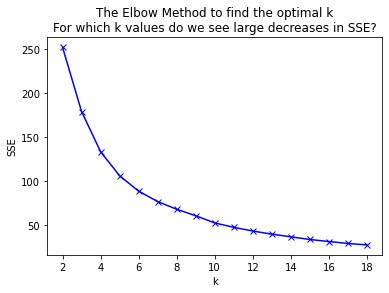

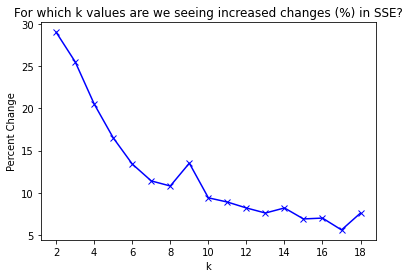

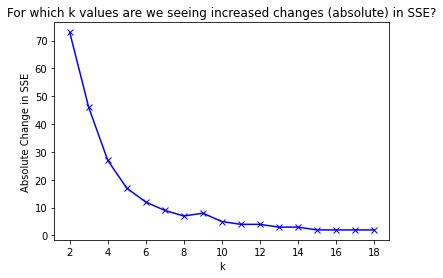

In [12]:
k_comparisons_df = find_k(X_train, cluster_vars, k_range)

In [13]:
k_comparisons_df

,k,sse,delta,pct_delta
0,2,251.778481,73.0,29.0
1,3,178.813898,46.0,25.5
2,4,133.247483,27.0,20.5
3,5,105.965942,17.0,16.5
4,6,88.527684,12.0,13.4
5,7,76.707167,9.0,11.4
6,8,67.983334,7.0,10.8
7,9,60.617207,8.0,13.5
8,10,52.457683,5.0,9.4
9,11,47.504981,4.0,8.9


In [14]:
def create_clusters(X_train, k, cluster_vars):
    # create kmean object
    kmeans = KMeans(n_clusters=k, random_state = 123)

    # fit to train and assign cluster ids to observations
    kmeans.fit(X_train[cluster_vars])

    return kmeans


In [15]:
kmeans = create_clusters(X_train, 6, cluster_vars)

In [16]:
kmeans

KMeans(n_clusters=6, random_state=123)

In [17]:
# get the centroids for each distinct cluster...

def get_centroids(kmeans, cluster_vars, cluster_name):
    # get the centroids for each distinct cluster...

    centroid_col_names = ['centroid_' + i for i in cluster_vars]

    centroid_df = pd.DataFrame(kmeans.cluster_centers_, 
                               columns=centroid_col_names).reset_index().rename(columns={'index': cluster_name})

    return centroid_df


In [18]:
centroid_df = get_centroids(kmeans, cluster_vars, cluster_name)

In [19]:
centroid_df

,interior_cluster,centroid_bath_bed_ratio,centroid_sq_feet
0,0,0.302184,0.154043
1,1,0.173107,0.139240
2,2,0.331483,0.545465
3,3,0.170710,0.243938
4,4,0.089820,0.114995
5,5,0.278786,0.336262


In [25]:
# label cluster for each observation in X_train (X[0] in our X list of dataframes), 
# X_validate (X[1]), & X_test (X[2])

def assign_clusters(df, kmeans, cluster_vars, cluster_name, centroid_df):

        clusters = pd.DataFrame(kmeans.predict(df[cluster_vars]), 
                            columns=[cluster_name], index=df.index)

        clusters_centroids = clusters.merge(centroid_df, on=cluster_name, copy=False).set_index(clusters.index.values)

        df = pd.concat([df, clusters_centroids], axis=1)
        return df


In [26]:
X = assign_clusters(X_train, kmeans, cluster_vars, cluster_name, centroid_df)

In [31]:
X

,bath_bed_ratio,sq_feet,interior_cluster,centroid_bath_bed_ratio,centroid_sq_feet
40409,0.345238,0.275165,5,0.278786,0.336262
23172,0.285714,0.269389,5,0.278786,0.336262
49707,0.196429,0.195132,5,0.278786,0.336262
36587,0.196429,0.151609,5,0.278786,0.336262
6405,0.166667,0.092616,5,0.278786,0.336262
...,...,...,...,...,...
19982,0.047619,0.087459,2,0.331483,0.545465
1766,0.196429,0.249381,2,0.331483,0.545465
5102,0.166667,0.117574,2,0.331483,0.545465
34399,0.166667,0.220606,2,0.331483,0.545465


In [29]:
pd.DataFrame(X.groupby(['interior_cluster', 'centroid_bath_bed_ratio', 'centroid_sq_feet'])['interior_cluster'].count())


,,,interior_cluster
interior_cluster,centroid_bath_bed_ratio,centroid_sq_feet,
0,0.302184,0.154043,3295
1,0.173107,0.139240,8449
2,0.331483,0.545465,641
3,0.170710,0.243938,5458
4,0.089820,0.114995,8093
5,0.278786,0.336262,2442


In [32]:
train.head()

,parcelid,logerror,bathrooms,bedrooms,sq_feet,fips,latitude,longitude,lotsizesquarefeet,regionidcity,...,taxrate,acres,acres_bin,sqft_bin,structure_dollar_per_sqft,structure_dollar_sqft_bin,land_dollar_per_sqft,lot_dollar_sqft_bin,bath_bed_ratio,cola
40409,14357041,-0.001358,3.5,3.0,2820.0,6059.0,33701815.0,-117717952.0,5492.0,52650.0,...,1.435365,0.126079,0.1,0.6,167.602837,0.5,119.641843,0.5,1.166667,0
23172,11185767,0.044035,4.0,4.0,2764.0,6037.0,34610159.0,-118192962.0,6624.0,40227.0,...,1.756942,0.152066,0.2,0.6,37.442475,0.1,9.500302,0.2,1.000000,0
49707,11471750,0.026075,3.0,4.0,2044.0,6037.0,33924794.0,-118423837.0,4967.0,55753.0,...,1.118434,0.114027,0.1,0.5,169.431996,0.5,158.594725,0.5,0.750000,0
36587,14234304,-0.051115,3.0,4.0,1622.0,6059.0,33795264.0,-117827395.0,7399.0,33252.0,...,1.110092,0.169858,0.2,0.4,64.356350,0.2,46.887282,0.3,0.750000,0
6405,12992951,0.110311,2.0,3.0,1050.0,6037.0,34048144.0,-117985938.0,5871.0,118895.0,...,1.282477,0.134780,0.1,0.2,89.523810,0.3,48.203032,0.3,0.666667,0
